##### este tiene ensambleal final con distintas semillas. 
###### Los mejores hiperparámetros fueron  {'num_iterations': 647, 'learning_rate': 0.22623100208594435, 'num_leaves': 911, 'feature_fraction': 0.904764460656521, 'bagging_fraction': 0.6769008662242174, 'bagging_freq': 7, 'max_depth': 14, 'min_data_in_leaf': 408, 'min_sum_hessian_in_leaf': 0.6015928929070524, 'min_gain_to_split': 0.04420159287960447, 'lambda_l1': 0.6038644111846289, 'lambda_l2': 9.271971954736248}
Mejor AUC: 0.940723026751078

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score


In [2]:
#leo el csv
df = pd.read_csv('C:/Users/Lucas/Downloads/Maestria/EyF/competencia_01_crudo.csv')

In [3]:

# calculo el periodo0 consecutivo
dsimple = df.copy()
dsimple["pos"] = range(1, len(dsimple) + 1)
dsimple["periodo0"] = (dsimple["foto_mes"] // 100) * 12 + (dsimple["foto_mes"] % 100)

# ordeno
dsimple = dsimple.sort_values(by=["numero_de_cliente", "periodo0"])

# calculo topes
periodo_ultimo = dsimple["periodo0"].max()
periodo_anteultimo = periodo_ultimo - 1

# calculo los leads de orden 1 y 2 (shift con signo negativo equivale a lead en R)
dsimple["periodo1"] = dsimple.groupby("numero_de_cliente")["periodo0"].shift(-1)
dsimple["periodo2"] = dsimple.groupby("numero_de_cliente")["periodo0"].shift(-2)

# asigno valores por defecto
dsimple["clase_ternaria"] = None
dsimple.loc[dsimple["periodo0"] < periodo_anteultimo, "clase_ternaria"] = "CONTINUA"

# calculo BAJA+1
cond_baja1 = (
    (dsimple["periodo0"] < periodo_ultimo)
    & (dsimple["periodo1"].isna() | (dsimple["periodo0"] + 1 < dsimple["periodo1"]))
)
dsimple.loc[cond_baja1, "clase_ternaria"] = "BAJA+1"

# calculo BAJA+2
cond_baja2 = (
    (dsimple["periodo0"] < periodo_anteultimo)
    & (dsimple["periodo0"] + 1 == dsimple["periodo1"])
    & (dsimple["periodo2"].isna() | (dsimple["periodo0"] + 2 < dsimple["periodo2"]))
)
dsimple.loc[cond_baja2, "clase_ternaria"] = "BAJA+2"

# vuelvo a ordenar por pos y pego al dataset original
dsimple = dsimple.sort_values(by="pos")
df["clase_ternaria"] = dsimple["clase_ternaria"].values

In [4]:
import numpy as np

# ordenar
df = df.sort_values(by=["foto_mes", "clase_ternaria", "numero_de_cliente"])

# contar registros por foto_mes y clase_ternaria
conteos = df.groupby(["foto_mes", "clase_ternaria"]).size().reset_index(name="N")

# parámetros
# ===============================================================
# 🔹 PARÁMETROS
# ===============================================================
PARAM = {
    "experimento": 4940,
    "semilla_primigenia": [878787],
    "train": [202101,202102, 202103],
    "train_final": [202101, 202102, 202103,202104],
    "future": [202106],
    "semilla_kaggle": 314159,
    "cortes": list(range(6000, 19001, 500)),
    "trainingstrategy": {
        "undersampling": 0.2
    }
}




In [5]:
import lightgbm as lgb


# cross validation folds
PARAM["hyperparametertuning"] = {}
PARAM["hyperparametertuning"]["xval_folds"] = 5



# parámetros fijos de LightGBM
PARAM["lgbm"] = {}
PARAM["lgbm"]["param_fijos"] = {
    "boosting_type": "gbdt",  # en python el nombre es boosting_type
    "objective": "binary",
    "metric": "auc",
    "first_metric_only": False,
    "boost_from_average": True,
    "feature_pre_filter": False,
    "force_row_wise": True,
    "verbosity": -100,

    "seed": PARAM["semilla_primigenia"],

    "max_depth": -1,
    "min_gain_to_split": 0.0,
    "min_sum_hessian_in_leaf": 0.001,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "max_bin": 31,

    "bagging_fraction": 1.0,
    "pos_bagging_fraction": 1.0,
    "neg_bagging_fraction": 1.0,
    "is_unbalance": False,
    "scale_pos_weight": 1.0,

    "drop_rate": 0.1,
    "max_drop": 50,
    "skip_drop": 0.5,

    "extra_trees": False,

    "num_iterations": 1200,
    "learning_rate": 0.02,
    "feature_fraction": 0.5,
    "num_leaves": 750,
    "min_data_in_leaf": 5000,
}

# espacio de hiperparámetros (para una BO en optuna/skopt)
PARAM["hyperparametertuning"]["hs"] = {
    "num_iterations": {"type": "int", "low": 10, "high": 1500},
    "learning_rate": {"type": "float", "low": 0.01, "high": 0.3},
    "feature_fraction": {"type": "float", "low": 0.4, "high": 1.0},
    "num_leaves": {"type": "int", "low": 500, "high": 2800},
    "min_data_in_leaf": {"type": "int", "low": 1, "high": 1500},
    "max_depth": {"type": "int", "low": 0, "high": 22},
    "lambda_l1": {"type": "float", "low": 0.0, "high": 15.0},
    "lambda_l2": {"type": "float", "low": 0.0, "high": 15.0},
    "min_gain_to_split": {"type": "float", "low": 0.0, "high": 10.0},
    "bagging_fraction": {"type": "float", "low": 0.4, "high": 1.0},
    "bagging_freq": {"type": "int", "low": 1, "high": 15},
    "min_sum_hessian_in_leaf": {"type": "float", "low": 0.001, "high": 20.0},

    # Nuevos sugeridos
    "boosting_type": {"type": "categorical", "choices": ["gbdt", "dart"]},
    "scale_pos_weight": {"type": "float", "low": 1.0, "high": 50.0},
    "max_bin": {"type": "int", "low": 25, "high": 100},
}






In [6]:
from sklearn.model_selection import train_test_split

def particionar(data, division, agrupa="", campo="fold", start=1, seed=None):
    data = data.copy().reset_index(drop=True)  # 🔹 reset indices
    total = sum(division)
    fracs = [d / total for d in division]  # pasar a proporciones
    bloques = list(range(start, start + len(division)))

    if agrupa:
        strat_col = data[agrupa]
    else:
        strat_col = None

    folds = np.zeros(len(data), dtype=int)
    idx = np.arange(len(data))

    for i, frac in enumerate(fracs):
        if i == len(fracs) - 1:
            chosen_idx = idx
        else:
            _, chosen_idx = train_test_split(
                idx,
                test_size=1-frac,
                stratify=strat_col.iloc[idx] if strat_col is not None else None,
                random_state=seed
            )
        folds[chosen_idx] = bloques[i]
        # actualizar lo que queda
        mask = np.isin(idx, chosen_idx, invert=True)
        idx = idx[mask]

    data[campo] = folds
    return data



In [7]:
def realidad_inicializar(pfuture, pparam):
    # datos para verificar la ganancia
    drealidad = pfuture[["numero_de_cliente", "foto_mes", "clase_ternaria"]].copy()

    drealidad = particionar(
        drealidad,
        division=[3, 7],
        agrupa="clase_ternaria",
        seed=PARAM["semilla_kaggle"]
    )
    return drealidad


In [8]:
def realidad_evaluar(prealidad, pprediccion):
    """
    Calcula la ganancia esperada.
    prealidad: DataFrame con columnas [numero_de_cliente, foto_mes, clase_ternaria, fold]
    pprediccion: DataFrame con columnas [numero_de_cliente, foto_mes, Predicted]
    """
    # merge para agregar predicciones
    merged = prealidad.merge(
        pprediccion[["numero_de_cliente", "foto_mes", "Predicted"]],
        on=["numero_de_cliente", "foto_mes"],
        how="left"
    )
    merged["predicted"] = merged["Predicted"].astype("Int64")
    merged = merged.drop(columns="Predicted")

    # tabla de conteos
    tbl = (
        merged.groupby(["fold", "predicted", "clase_ternaria"])
        .size()
        .reset_index(name="qty")
    )

    # función de ganancia
    def ganancia(subtbl):
        return (subtbl["qty"] * np.where(subtbl["clase_ternaria"]=="BAJA+2", 780000, -20000)).sum()

    res = {}
    # fold==1 → public (dividido por 0.3)
    mask_pub = (tbl["fold"]==1) & (tbl["predicted"]==1)
    res["public"] = ganancia(tbl[mask_pub]) / 0.3

    # fold==2 → private (dividido por 0.7)
    mask_priv = (tbl["fold"]==2) & (tbl["predicted"]==1)
    res["private"] = ganancia(tbl[mask_priv]) / 0.7

    # total sin dividir
    mask_total = tbl["predicted"]==1
    res["total"] = ganancia(tbl[mask_total])

    return res


In [9]:
# Aseguramos que la columna mpayroll sea numérica
df["mpayroll"] = pd.to_numeric(df["mpayroll"], errors="coerce")

# 1️⃣ Crear una máscara de clientes que tienen mpayroll no nulo en 202105 y 202106
clientes_validos = df.query("foto_mes in [202105, 202106]") \
    .pivot(index="numero_de_cliente", columns="foto_mes", values="mpayroll") \
    .dropna(subset=[202105, 202106]) \
    .index

# 2️⃣ Copiar mpayroll a una nueva columna
df["mpayroll_norm"] = df["mpayroll"]

# 3️⃣ Aplicar la normalización (multiplicar por 0.7 solo en 202106 y clientes válidos)
mask = (df["foto_mes"] == 202106) & (df["numero_de_cliente"].isin(clientes_validos))
df.loc[mask, "mpayroll_norm"] = df.loc[mask, "mpayroll"] * 0.7

In [10]:
import numpy as np
import pandas as pd

def rank_separate_group(df, columns, group_col="foto_mes"):
    """
    Genera columnas *_ranked por cada variable monetaria,
    aplicando ranking separado por signo y por grupo temporal (foto_mes),
    tolerante a NaN.
    """
    df = df.copy()

    for col in columns:
        new_col = f"{col}_ranked"
        df[new_col] = np.nan  # inicializa la columna

        def rank_group(g):
            s = g[col]
            ranked = pd.Series(index=s.index, dtype=float)

            # negativos
            mask_neg = (s < 0) & s.notna()
            if mask_neg.any():
                ranked.loc[mask_neg] = -s[mask_neg].rank(method="average", ascending=False)

            # positivos
            mask_pos = (s > 0) & s.notna()
            if mask_pos.any():
                ranked.loc[mask_pos] = s[mask_pos].rank(method="average", ascending=True)

            # ceros
            mask_zero = (s == 0) & s.notna()
            if mask_zero.any():
                ranked.loc[mask_zero] = 0

            return ranked

        # aplicar ranking solo a filas válidas del grupo
        ranked_series = df.groupby(group_col, group_keys=False).apply(rank_group)
        df.loc[ranked_series.index, new_col] = ranked_series

    return df


cols_monetarias = [
    "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen", 
    "mcuenta_corriente_adicional", "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_adicional", 
    "mcaja_ahorro_dolares", "mcuentas_saldo", "mautoservicio", "mtarjeta_visa_consumo", "mtarjeta_master_consumo", 
    "mprestamos_personales", "mprestamos_prendarios", "mprestamos_hipotecarios", "mplazo_fijo_dolares", 
    "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares", "minversion2", "mpayroll", "mpayroll2", 
    "mcuenta_debitos_automaticos", "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", 
    "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos", 
    "mtarjeta_master_descuentos", "mcomisiones_mantenimiento", "mcomisiones_otras", "mforex_buy", "mforex_sell", 
    "mtransferencias_recibidas", "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_depositados", 
    "mcheques_emitidos", "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados", "matm", "matm_other", 
    "Master_mfinanciacion_limite", "Master_msaldototal", "Master_msaldopesos", "Master_msaldodolares", 
    "Master_mconsumospesos", "Master_mconsumosdolares", "Master_mlimitecompra", "Master_madelantopesos", 
    "Master_madelantodolares", "Master_mpagado", "Master_mpagospesos", "Master_mpagosdolares", 
    "Master_mconsumototal", "Master_mpagominimo", "Visa_mfinanciacion_limite", "Visa_msaldototal", 
    "Visa_msaldopesos", "Visa_msaldodolares", "Visa_mconsumospesos", "Visa_mconsumosdolares", 
    "Visa_mlimitecompra", "Visa_madelantopesos", "Visa_madelantodolares", "Visa_mpagado", "Visa_mpagospesos", 
    "Visa_mpagosdolares", "Visa_mconsumototal", "Visa_mpagominimo","mpayroll_norm"
]

# aplicar ranking neutralizado por mes
df = rank_separate_group(df, cols_monetarias)

In [11]:
# --- 0️⃣ Preparación ---
df = df.sort_values(["numero_de_cliente", "foto_mes"])

# columnas a excluir
excluir = {"numero_de_cliente", "foto_mes", "clase_ternaria"}
columnas = [c for c in df.columns if c not in excluir]

# --- 1️⃣ Generar lag y delta de orden 1, 2 y 3---
for col in columnas:
    for lag in [1, 2, 3]:
        df[f"{col}_lag{lag}"] = df.groupby("numero_de_cliente")[col].shift(lag)
        df[f"{col}_delta{lag}"] = df[col] - df[f"{col}_lag{lag}"]



C:\Users\Lucas\AppData\Local\Temp\ipykernel_14208\597707953.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_delta{lag}"] = df[col] - df[f"{col}_lag{lag}"]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_14208\597707953.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df.groupby("numero_de_cliente")[col].shift(lag)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_14208\597707953.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

In [12]:
#me dejo una copia por si falla algo así no tengo que correr todo de vuelta
dft=df.copy()

MemoryError: Unable to allocate 11.1 GiB for an array with shape (1526, 978439) and data type float64

##### saco las features no importantes que obtuve de la primer tirada

In [12]:
# === Feature importance filtering ===
archivo_importancia = r"C:\Users\Lucas\Proyectos cursor\experimentos\expnuevo2\exp4940\impo_nuevo_n.txt"
features_df = pd.read_csv(archivo_importancia, sep="\t")

# Filtrar features con importancia >= 100
features_filtradas = features_df.loc[features_df["Importance"] >= 10, "Feature"].tolist()

# Columnas extra que no deben perderse
cols_extra = ["clase_ternaria","foto_mes"]

# Crear el dataframe filtrado
df_filtrado = df[cols_extra + [c for c in features_filtradas if c in df.columns]].copy()

In [13]:
df=df_filtrado.copy()

In [15]:
import numpy as np
import pandas as pd

# 1️⃣ Filtrar por meses de training
dataset_train = df[df["foto_mes"].isin(PARAM["train"])].copy()

# 2️⃣ Clase binaria
dataset_train["clase01"] = np.where(
    dataset_train["clase_ternaria"].isin(["BAJA+1", "BAJA+2"]), 1, 0
)

# 3️⃣ Undersampling de CONTINUA
np.random.seed(PARAM["semilla_primigenia"][0])  # recordá que es lista
dataset_train["azar"] = np.random.rand(len(dataset_train))
mask_training = (
    (dataset_train["foto_mes"].isin(PARAM["train"])) &
    ((dataset_train["azar"] <= PARAM["trainingstrategy"]["undersampling"]) |
     (dataset_train["clase_ternaria"].isin(["BAJA+1", "BAJA+2"])))
)
dataset_train = dataset_train.loc[mask_training].copy()

# 4️⃣ Seleccionar columnas a usar
campos_buenos = dataset_train.columns.difference(
    ["clase_ternaria", "clase01", "azar"]
)

X_train = dataset_train[campos_buenos].copy()
y_train = dataset_train["clase01"].copy()

# 5️⃣ Convertir categóricas a numéricas si las hay
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category').cat.codes

# 6️⃣ Asegurar tipos correctos para LightGBM
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)

# ✅ Listo para usar en Optuna
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Balance clases:\n", y_train.value_counts())



Shape X_train: (101496, 375)
Shape y_train: (101496,)
Balance clases:
 clase01
0    96196
1     5300
Name: count, dtype: int64


##### este creo que reemplaza el código anterior:

In [16]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Semilla
seed = 878787
seeds = [seed]

# Función de Optuna para estimar AUC con CV
def EstimarGanancia_AUC_lightgbm(trial, X, y, seeds):
    aucs_semillas = []

    for seed in seeds:
        param = {
            # Configs fijas
            "objective": "binary",
            "metric": "auc",
            "verbosity": -1,
            "seed": seed,

            # Hiperparámetros a tunear
            "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
            "num_iterations": trial.suggest_int("num_iterations", 10, 1500),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 500, 2800),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "max_depth": trial.suggest_int("max_depth", 0, 22),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1500),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 15.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 15.0),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 10.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 15),
            "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.001, 20.0),

            # Nuevos sugeridos
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 50.0),
            "max_bin": trial.suggest_int("max_bin", 25, 100),
        }



        cv = StratifiedKFold(
            n_splits=PARAM["hyperparametertuning"]["xval_folds"],
            shuffle=True,
            random_state=seed
        )

        aucs = []
        for train_idx, valid_idx in cv.split(X, y):
            lgb_train = lgb.Dataset(X.iloc[train_idx].astype(np.float32), label=y.iloc[train_idx].astype(np.int32))
            lgb_valid = lgb.Dataset(X.iloc[valid_idx].astype(np.float32), label=y.iloc[valid_idx].astype(np.int32))

            model = lgb.train(
                param,
                lgb_train,
                valid_sets=[lgb_valid],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
            )
            preds = model.predict(X.iloc[valid_idx])
            auc = roc_auc_score(y.iloc[valid_idx], preds)
            aucs.append(auc)

        aucs_semillas.append(np.mean(aucs))

    return np.mean(aucs_semillas)



C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:

# Crear el estudio
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.RandomSampler(seed=seed)
)

# Primeras 20 pruebas random
study.optimize(
    lambda trial: EstimarGanancia_AUC_lightgbm(trial, X_train, y_train, seeds),
    n_trials=30
)

# Luego 30 pruebas con TPE
study.sampler = optuna.samplers.TPESampler(seed=seed)
study.optimize(
    lambda trial: EstimarGanancia_AUC_lightgbm(trial, X_train, y_train, seeds),
    n_trials=40
)

# Guardar resultados
tb_bayesiana = study.trials_dataframe(attrs=("number", "value", "params", "state")).rename(columns={"value": "AUC"})
tb_bayesiana["iter"] = tb_bayesiana.index + 1
tb_bayesiana.sort_values(by="AUC", ascending=False).to_csv("BO_log.txt", sep="\t", index=False)

PARAM["out"] = {
    "lgbm": {
        "mejores_hiperparametros": study.best_trial.params,
        "AUC": study.best_trial.value
    }
}
print("✅ Mejores hiperparámetros:", study.best_trial.params)
print("✅ Mejor AUC:", study.best_trial.value)




[I 2025-10-09 23:49:35,267] A new study created in memory with name: no-name-84cbe4a9-95b7-452e-bead-8b17b2a5fc7f


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[230]	valid_0's auc: 0.933588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's auc: 0.93722
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[270]	valid_0's auc: 0.928301
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[210]	valid_0's auc: 0.930893
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.936105


[I 2025-10-09 23:50:14,440] Trial 0 finished with value: 0.9332208004856636 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 792, 'learning_rate': 0.12225517684754826, 'num_leaves': 2173, 'feature_fraction': 0.5474910314574816, 'max_depth': 12, 'min_data_in_leaf': 699, 'lambda_l1': 11.364219835973833, 'lambda_l2': 10.587416170941841, 'min_gain_to_split': 9.31713699079583, 'bagging_fraction': 0.8497372222417328, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 0.7384833885205929, 'scale_pos_weight': 26.29157771380609, 'max_bin': 82}. Best is trial 0 with value: 0.9332208004856636.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's auc: 0.93079
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.933242
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.923086
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.928402
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's auc: 0.936364


[I 2025-10-10 00:00:43,003] Trial 3 finished with value: 0.93037672457983 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 344, 'learning_rate': 0.19751552165303163, 'num_leaves': 1664, 'feature_fraction': 0.9884991998440884, 'max_depth': 22, 'min_data_in_leaf': 228, 'lambda_l1': 3.7874830689391676, 'lambda_l2': 10.531878052720483, 'min_gain_to_split': 4.195709152358756, 'bagging_fraction': 0.7353577602300094, 'bagging_freq': 12, 'min_sum_hessian_in_leaf': 16.702865306562057, 'scale_pos_weight': 42.32516657436609, 'max_bin': 56}. Best is trial 2 with value: 0.9362458872564297.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's auc: 0.921374
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's auc: 0.927816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's auc: 0.916737
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's auc: 0.925091
Training until validation scores don't improve for 50 rounds


[I 2025-10-10 00:00:54,376] Trial 4 finished with value: 0.9236945575669442 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 1244, 'learning_rate': 0.23759189065873848, 'num_leaves': 1263, 'feature_fraction': 0.8606159362039743, 'max_depth': 3, 'min_data_in_leaf': 1215, 'lambda_l1': 9.065860731493368, 'lambda_l2': 14.439747590356081, 'min_gain_to_split': 3.032701364415259, 'bagging_fraction': 0.4242177341316495, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 9.485769957819821, 'scale_pos_weight': 47.81294957717391, 'max_bin': 32}. Best is trial 2 with value: 0.9362458872564297.


Early stopping, best iteration is:
[84]	valid_0's auc: 0.927454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[259]	valid_0's auc: 0.931695
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.935253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[234]	valid_0's auc: 0.925601
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[282]	valid_0's auc: 0.932558
Training until validation scores don't improve for 50 rounds


[I 2025-10-10 00:01:12,987] Trial 5 finished with value: 0.9318704675505461 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 1259, 'learning_rate': 0.12457339613690484, 'num_leaves': 1296, 'feature_fraction': 0.8452703104159863, 'max_depth': 21, 'min_data_in_leaf': 1281, 'lambda_l1': 11.872316603351297, 'lambda_l2': 0.6106391887910373, 'min_gain_to_split': 0.9627147993500484, 'bagging_fraction': 0.5065580786614856, 'bagging_freq': 14, 'min_sum_hessian_in_leaf': 12.058302711586734, 'scale_pos_weight': 37.20409755596174, 'max_bin': 26}. Best is trial 2 with value: 0.9362458872564297.


Early stopping, best iteration is:
[159]	valid_0's auc: 0.934245
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's auc: 0.929787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's auc: 0.935613
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's auc: 0.923742
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.927658
Training until validation scores don't improve for 50 rounds


[I 2025-10-10 00:01:35,238] Trial 6 finished with value: 0.930082638993081 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 561, 'learning_rate': 0.17618322853587112, 'num_leaves': 1203, 'feature_fraction': 0.4503064350260201, 'max_depth': 16, 'min_data_in_leaf': 1165, 'lambda_l1': 6.599835547629789, 'lambda_l2': 5.693796896366364, 'min_gain_to_split': 6.390210091583545, 'bagging_fraction': 0.6542302674616324, 'bagging_freq': 10, 'min_sum_hessian_in_leaf': 16.651300551238236, 'scale_pos_weight': 3.5822215146159495, 'max_bin': 67}. Best is trial 2 with value: 0.9362458872564297.


Early stopping, best iteration is:
[83]	valid_0's auc: 0.933612


C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lig

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's auc: 0.931588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.936563
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's auc: 0.926018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.930582
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's auc: 0.935568


[I 2025-10-10 00:06:18,455] Trial 8 finished with value: 0.9320638357135007 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 1280, 'learning_rate': 0.16474011352884363, 'num_leaves': 1344, 'feature_fraction': 0.49795562034944985, 'max_depth': 10, 'min_data_in_leaf': 768, 'lambda_l1': 10.85797181107384, 'lambda_l2': 6.817124627571395, 'min_gain_to_split': 8.904750409915994, 'bagging_fraction': 0.6647726140450444, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 5.694443131770792, 'scale_pos_weight': 17.61632226539379, 'max_bin': 70}. Best is trial 2 with value: 0.9362458872564297.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[593]	valid_0's auc: 0.938512
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[682]	valid_0's auc: 0.943772
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[688]	valid_0's auc: 0.935478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[589]	valid_0's auc: 0.94079
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[544]	valid_0's auc: 0.942862


[I 2025-10-10 00:13:45,776] Trial 10 finished with value: 0.9402827705213866 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 816, 'learning_rate': 0.0630946452762805, 'num_leaves': 1934, 'feature_fraction': 0.907593977727425, 'max_depth': 17, 'min_data_in_leaf': 134, 'lambda_l1': 0.8781329101264995, 'lambda_l2': 2.891694136024892, 'min_gain_to_split': 0.020750712643884395, 'bagging_fraction': 0.9434327601296862, 'bagging_freq': 12, 'min_sum_hessian_in_leaf': 3.434389185185518, 'scale_pos_weight': 21.88266235984722, 'max_bin': 44}. Best is trial 10 with value: 0.9402827705213866.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\P

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.922761
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.925982
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.916633
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.923585
Training until validation scores don't improve for 50 rounds


[I 2025-10-10 00:17:42,590] Trial 13 finished with value: 0.9232075165031814 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 34, 'learning_rate': 0.013204299589175392, 'num_leaves': 1291, 'feature_fraction': 0.6089721087759206, 'max_depth': 16, 'min_data_in_leaf': 44, 'lambda_l1': 13.643759952578618, 'lambda_l2': 10.265750772333572, 'min_gain_to_split': 5.5635466473467785, 'bagging_fraction': 0.9819878900428428, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 3.44160237782896, 'scale_pos_weight': 13.101766139039928, 'max_bin': 90}. Best is trial 10 with value: 0.9402827705213866.


Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.927076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[191]	valid_0's auc: 0.92827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.93005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's auc: 0.919647
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.921148
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.929771


[I 2025-10-10 00:18:07,408] Trial 14 finished with value: 0.9257770775571595 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 814, 'learning_rate': 0.26248442960634205, 'num_leaves': 1164, 'feature_fraction': 0.5608673800727105, 'max_depth': 7, 'min_data_in_leaf': 494, 'lambda_l1': 4.290298426538628, 'lambda_l2': 5.707085873226939, 'min_gain_to_split': 1.4456340981578475, 'bagging_fraction': 0.6484300119474493, 'bagging_freq': 15, 'min_sum_hessian_in_leaf': 7.62823083560018, 'scale_pos_weight': 46.611112238251835, 'max_bin': 88}. Best is trial 10 with value: 0.9402827705213866.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's auc: 0.931417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid_0's auc: 0.937409
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.92232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.929325
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's auc: 0.935058


[I 2025-10-10 00:18:26,756] Trial 15 finished with value: 0.9311057207713975 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 553, 'learning_rate': 0.1778702319437598, 'num_leaves': 2481, 'feature_fraction': 0.6841734786382347, 'max_depth': 6, 'min_data_in_leaf': 878, 'lambda_l1': 7.40855931060639, 'lambda_l2': 1.2361601485154594, 'min_gain_to_split': 2.693711768675083, 'bagging_fraction': 0.9522200012091353, 'bagging_freq': 14, 'min_sum_hessian_in_leaf': 0.6190728668902801, 'scale_pos_weight': 38.443876855763655, 'max_bin': 35}. Best is trial 10 with value: 0.9402827705213866.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	valid_0's auc: 0.932484
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[232]	valid_0's auc: 0.938508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's auc: 0.925789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's auc: 0.932759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's auc: 0.938281


[I 2025-10-10 00:18:58,647] Trial 16 finished with value: 0.933564198571456 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 698, 'learning_rate': 0.08851155315299494, 'num_leaves': 1345, 'feature_fraction': 0.4926157443464741, 'max_depth': 21, 'min_data_in_leaf': 386, 'lambda_l1': 8.577108434080671, 'lambda_l2': 4.973115598932738, 'min_gain_to_split': 7.3580105475108475, 'bagging_fraction': 0.6537044159804061, 'bagging_freq': 11, 'min_sum_hessian_in_leaf': 11.078147557968125, 'scale_pos_weight': 38.10617302475576, 'max_bin': 89}. Best is trial 10 with value: 0.9402827705213866.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's auc: 0.930145
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's auc: 0.930081
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's auc: 0.922556
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.927963
Training until validation scores don't improve for 50 rounds


[I 2025-10-10 00:34:09,088] Trial 23 finished with value: 0.9280174414376654 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 825, 'learning_rate': 0.1602575365499321, 'num_leaves': 787, 'feature_fraction': 0.7653096224995828, 'max_depth': 7, 'min_data_in_leaf': 711, 'lambda_l1': 5.949826156627805, 'lambda_l2': 1.8265318459653235, 'min_gain_to_split': 9.621802421590122, 'bagging_fraction': 0.4574437250721757, 'bagging_freq': 12, 'min_sum_hessian_in_leaf': 17.9215880113613, 'scale_pos_weight': 47.23629646261154, 'max_bin': 36}. Best is trial 10 with value: 0.9402827705213866.


Early stopping, best iteration is:
[105]	valid_0's auc: 0.929342
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.923101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.926621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.915352
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.919714
Training until validation scores don't improve for 50 rounds


[I 2025-10-10 00:34:28,174] Trial 24 finished with value: 0.9212792118739115 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 1123, 'learning_rate': 0.2863105716966383, 'num_leaves': 1666, 'feature_fraction': 0.4244377976220986, 'max_depth': 4, 'min_data_in_leaf': 477, 'lambda_l1': 4.649708241398461, 'lambda_l2': 7.110296901433986, 'min_gain_to_split': 7.360504005379209, 'bagging_fraction': 0.40883223484014525, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 19.80038011703333, 'scale_pos_weight': 32.08319965262398, 'max_bin': 100}. Best is trial 10 with value: 0.9402827705213866.


Early stopping, best iteration is:
[62]	valid_0's auc: 0.921608


C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lig

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.927477
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.929453
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	valid_0's auc: 0.919234
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[152]	valid_0's auc: 0.924352
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.926737


[I 2025-10-10 00:35:02,704] Trial 26 finished with value: 0.9254503565849646 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 588, 'learning_rate': 0.2831216438969559, 'num_leaves': 1938, 'feature_fraction': 0.40270097913339487, 'max_depth': 21, 'min_data_in_leaf': 1250, 'lambda_l1': 6.770091221238525, 'lambda_l2': 3.9162223822328053, 'min_gain_to_split': 6.311894701271317, 'bagging_fraction': 0.594659620875926, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 0.9764738620706959, 'scale_pos_weight': 26.763570540265864, 'max_bin': 59}. Best is trial 10 with value: 0.9402827705213866.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\P

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's auc: 0.935879
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's auc: 0.940255
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[211]	valid_0's auc: 0.929266
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's auc: 0.933556
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's auc: 0.940084


[I 2025-10-10 01:27:56,042] Trial 39 finished with value: 0.9358079840629842 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 674, 'learning_rate': 0.071752097175894, 'num_leaves': 2787, 'feature_fraction': 0.8809921301896656, 'max_depth': 16, 'min_data_in_leaf': 888, 'lambda_l1': 2.977321991601591, 'lambda_l2': 0.7317788519646524, 'min_gain_to_split': 0.06411584953910456, 'bagging_fraction': 0.8805746666988783, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 9.109912456090807, 'scale_pos_weight': 7.345180847517108, 'max_bin': 40}. Best is trial 10 with value: 0.9402827705213866.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's auc: 0.929662
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.933555
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.926009
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.93063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.936602


[I 2025-10-10 01:42:18,716] Trial 46 finished with value: 0.9312916134189313 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 457, 'learning_rate': 0.14257741762677195, 'num_leaves': 2580, 'feature_fraction': 0.7863867306625968, 'max_depth': 9, 'min_data_in_leaf': 153, 'lambda_l1': 0.5164460300314642, 'lambda_l2': 0.15184110594345082, 'min_gain_to_split': 3.6816609169247996, 'bagging_fraction': 0.995911160429655, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 1.9155112271866641, 'scale_pos_weight': 11.171689492624719, 'max_bin': 55}. Best is trial 10 with value: 0.9402827705213866.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.932989
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's auc: 0.940162
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's auc: 0.931386
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.935744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.938195


[I 2025-10-10 01:43:36,765] Trial 48 finished with value: 0.9356950752742283 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 438, 'learning_rate': 0.11209549298772817, 'num_leaves': 2223, 'feature_fraction': 0.9041977992163261, 'max_depth': 11, 'min_data_in_leaf': 285, 'lambda_l1': 0.7283085159667864, 'lambda_l2': 1.0215793685447858, 'min_gain_to_split': 0.8538875290977814, 'bagging_fraction': 0.9309728011916345, 'bagging_freq': 4, 'min_sum_hessian_in_leaf': 0.09193206643635854, 'scale_pos_weight': 10.285712466834735, 'max_bin': 73}. Best is trial 10 with value: 0.9402827705213866.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-package

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's auc: 0.933143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.934278
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.926891
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.931638
Training until validation scores don't improve for 50 rounds


[I 2025-10-10 01:45:29,338] Trial 50 finished with value: 0.9321399522462824 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 316, 'learning_rate': 0.14476050172530408, 'num_leaves': 2036, 'feature_fraction': 0.7239245909232044, 'max_depth': 17, 'min_data_in_leaf': 8, 'lambda_l1': 5.335110009952509, 'lambda_l2': 2.2478962736370756, 'min_gain_to_split': 2.6455363503319687, 'bagging_fraction': 0.9759974604732531, 'bagging_freq': 2, 'min_sum_hessian_in_leaf': 3.478085473996498, 'scale_pos_weight': 4.92423020448107, 'max_bin': 41}. Best is trial 10 with value: 0.9402827705213866.


Early stopping, best iteration is:
[95]	valid_0's auc: 0.934798


C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lig

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's auc: 0.933174
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[301]	valid_0's auc: 0.938686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.927561
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's auc: 0.935039
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's auc: 0.939673


[I 2025-10-10 02:15:41,815] Trial 58 finished with value: 0.9348263975981054 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 536, 'learning_rate': 0.12566839532526733, 'num_leaves': 1747, 'feature_fraction': 0.9966204370295578, 'max_depth': 13, 'min_data_in_leaf': 100, 'lambda_l1': 8.194542093964131, 'lambda_l2': 3.283681034571946, 'min_gain_to_split': 1.0659417277514667, 'bagging_fraction': 0.9159583331031577, 'bagging_freq': 2, 'min_sum_hessian_in_leaf': 0.07664398423818525, 'scale_pos_weight': 16.392894689559952, 'max_bin': 64}. Best is trial 51 with value: 0.9405421052864336.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[226]	valid_0's auc: 0.930995
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.93779
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's auc: 0.930189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	valid_0's auc: 0.933451
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.938614


[I 2025-10-10 02:41:42,781] Trial 65 finished with value: 0.9342078555569445 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 757, 'learning_rate': 0.12943475754743552, 'num_leaves': 2282, 'feature_fraction': 0.9820105389416569, 'max_depth': 14, 'min_data_in_leaf': 55, 'lambda_l1': 6.716178484720904, 'lambda_l2': 2.5908206986163496, 'min_gain_to_split': 1.1962994934563, 'bagging_fraction': 0.9068574472065047, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 1.661763001619979, 'scale_pos_weight': 24.81899473640553, 'max_bin': 61}. Best is trial 51 with value: 0.9405421052864336.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[378]	valid_0's auc: 0.937445
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[565]	valid_0's auc: 0.941251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid_0's auc: 0.931584
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[458]	valid_0's auc: 0.937146
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[428]	valid_0's auc: 0.939443


[I 2025-10-10 02:54:34,550] Trial 69 finished with value: 0.9373735769453754 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 623, 'learning_rate': 0.056453628128335306, 'num_leaves': 1978, 'feature_fraction': 0.9514712593449135, 'max_depth': 11, 'min_data_in_leaf': 2, 'lambda_l1': 6.259692439104557, 'lambda_l2': 1.326930079234978, 'min_gain_to_split': 1.1319099651337658, 'bagging_fraction': 0.751507847416857, 'bagging_freq': 2, 'min_sum_hessian_in_leaf': 2.722956991026638, 'scale_pos_weight': 13.686697191940983, 'max_bin': 69}. Best is trial 51 with value: 0.9405421052864336.


✅ Mejores hiperparámetros: {'boosting_type': 'dart', 'num_iterations': 650, 'learning_rate': 0.09447556289364047, 'num_leaves': 2451, 'feature_fraction': 0.8323251056180896, 'max_depth': 15, 'min_data_in_leaf': 112, 'lambda_l1': 3.3661673895549624, 'lambda_l2': 0.024603888050272582, 'min_gain_to_split': 0.9548524257248387, 'bagging_fraction': 0.9422508753653047, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 4.9762082919650705, 'scale_pos_weight': 6.124837396332106, 'max_bin': 60}
✅ Mejor AUC: 0.9405421052864336


In [18]:
tb_bayesiana = study.trials_dataframe(attrs=("number", "value", "params", "state"))
tb_bayesiana = tb_bayesiana.rename(columns={"value": "y"})
tb_bayesiana["iter"] = tb_bayesiana.index + 1
tb_bayesiana = tb_bayesiana.sort_values(by="y", ascending=False).reset_index(drop=True)
tb_bayesiana.to_csv("BO_log.txt", sep="\t", index=False)
mejores_hiperparametros = study.best_trial.params
mejor_auc = study.best_trial.value
print("Mejores hiperparámetros:", mejores_hiperparametros)
print("Mejor AUC:", mejor_auc)
PARAM["out"] = {"lgbm": {"mejores_hiperparametros": mejores_hiperparametros, "y": mejor_auc}}


Mejores hiperparámetros: {'boosting_type': 'dart', 'num_iterations': 650, 'learning_rate': 0.09447556289364047, 'num_leaves': 2451, 'feature_fraction': 0.8323251056180896, 'max_depth': 15, 'min_data_in_leaf': 112, 'lambda_l1': 3.3661673895549624, 'lambda_l2': 0.024603888050272582, 'min_gain_to_split': 0.9548524257248387, 'bagging_fraction': 0.9422508753653047, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 4.9762082919650705, 'scale_pos_weight': 6.124837396332106, 'max_bin': 60}
Mejor AUC: 0.9405421052864336


In [19]:
import yaml

# 1. Guardar PARAM en YAML
with open("C:/Users/Lucas/Proyectos cursor/PARAM_9k_featureExt_lag3_ymaxdepth.yml", "w") as f:
    yaml.dump(PARAM, f, default_flow_style=False, sort_keys=False)

# 2. Imprimir los mejores hiperparámetros
print(PARAM["out"]["lgbm"]["mejores_hiperparametros"])

# 3. Imprimir el mejor AUC
print(PARAM["out"]["lgbm"]["y"])

{'boosting_type': 'dart', 'num_iterations': 650, 'learning_rate': 0.09447556289364047, 'num_leaves': 2451, 'feature_fraction': 0.8323251056180896, 'max_depth': 15, 'min_data_in_leaf': 112, 'lambda_l1': 3.3661673895549624, 'lambda_l2': 0.024603888050272582, 'min_gain_to_split': 0.9548524257248387, 'bagging_fraction': 0.9422508753653047, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 4.9762082919650705, 'scale_pos_weight': 6.124837396332106, 'max_bin': 60}
0.9405421052864336


In [20]:
import os
import lightgbm as lgb
import numpy as np
import pandas as pd

# 1. Carpeta del experimento
# 1. Ruta base de experimentos
base_dir = "C:/Users/Lucas/Proyectos cursor/experimentos/exp9k_featureExt_lag3_maxdepth"

# 2. Carpeta del experimento
experimento = f"exp{PARAM['experimento']}"
exp_dir = os.path.join(base_dir, experimento)

# 3. Crear carpeta si no existe
os.makedirs(exp_dir, exist_ok=True)

# 4. Cambiar el cwd a esa carpeta
os.chdir(exp_dir)


In [21]:

# 2. Crear variable clase01
df["clase01"] = np.where(
    df["clase_ternaria"].isin(["BAJA+1", "BAJA+2"]), 1, 0
)



In [22]:
# Entrenamiento para evaluar en 202104
dataset_train_eval = df[df["foto_mes"].isin([202101, 202102, 202103])].copy()
dataset_test_eval  = df[df["foto_mes"] == 202104].copy()

# X_train / y_train
X_train_eval = dataset_train_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_eval = np.where(dataset_train_eval["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)

# X_test / y_test
X_test_eval = dataset_test_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_test_eval = np.where(dataset_test_eval["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)



In [23]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# supondremos que 'study' es el último estudio que corriste para la última seed
# si querés combinar los resultados de todas las seeds, tendrías que concatenar los trials en un solo study o usar df_resultados

# 1️⃣ Historial de optimización (objetivo vs trial)
fig1 = plot_optimization_history(study)
fig1.show()

# 2️⃣ Importancia de cada hiperparámetro
fig2 = plot_param_importances(study)
fig2.show()

# 3️⃣ Coordenadas paralelas: cada línea es un trial
fig3 = plot_parallel_coordinate(study)
fig3.show()

# 4️⃣ Slice plot: distribuciones de score vs valor de cada hiperparámetro
fig4 = plot_slice(study)
fig4.show()

Entrenando modelo con seed = 878787 (evaluación 202104)
Entrenando modelo con seed = 131213 (evaluación 202104)
Entrenando modelo con seed = 999199 (evaluación 202104)
Entrenando modelo con seed = 611033 (evaluación 202104)
Entrenando modelo con seed = 100129 (evaluación 202104)
Entrenando modelo con seed = 278787 (evaluación 202104)
Entrenando modelo con seed = 991999 (evaluación 202104)
Entrenando modelo con seed = 378399 (evaluación 202104)
Entrenando modelo con seed = 777781 (evaluación 202104)
Entrenando modelo con seed = 202021 (evaluación 202104)

Seed 878787 (envíos 6000-19000):
Total ganancia: -36820000
Público (BAJA+2): 217620000
Privado (otros): -254440000

Seed 131213 (envíos 6000-19000):
Total ganancia: -35220000
Público (BAJA+2): 219180000
Privado (otros): -254400000

Seed 999199 (envíos 6000-19000):
Total ganancia: -40820000
Público (BAJA+2): 213720000
Privado (otros): -254540000

Seed 611033 (envíos 6000-19000):
Total ganancia: -39220000
Público (BAJA+2): 215280000
Priv

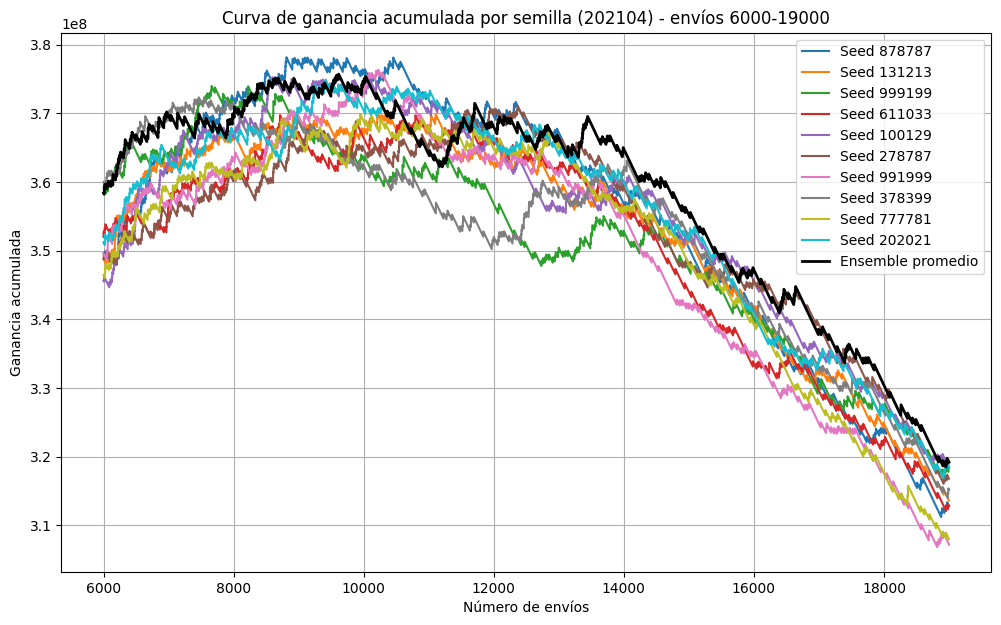

In [24]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

SEEDS = [878787, 131213, 999199, 611033, 100129,278787,991999,378399,777781, 202021]
MAX_ENVIOS = 40000  # límite de envíos
RANGO_ENV = (6000, 19000)  # rango que queremos visualizar

# --------------------------
# 1️⃣ Preparar datasets
# --------------------------
dataset_train_eval = df[df["foto_mes"].isin([202101, 202102, 202103])].copy()
X_train_eval = dataset_train_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_eval = np.where(dataset_train_eval["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)

dataset_test_eval = df[df["foto_mes"] == 202104].copy()
X_test_eval = dataset_test_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)

# --------------------------
# 2️⃣ Preparar parámetros finales
# --------------------------
param_final = PARAM["lgbm"]["param_fijos"].copy()
param_final.update(PARAM["out"]["lgbm"]["mejores_hiperparametros"])
param_normalizado = copy.deepcopy(param_final)
param_normalizado["min_data_in_leaf"] = int(round(
    param_final["min_data_in_leaf"] / PARAM["trainingstrategy"]["undersampling"]
))

# --------------------------
# 3️⃣ Entrenamiento ensemble
# --------------------------
modelos_eval = []
preds_ensemble_eval = np.zeros(len(dataset_test_eval))

for seed in SEEDS:
    params_seed = copy.deepcopy(param_normalizado)
    params_seed["seed"] = seed

    print(f"Entrenando modelo con seed = {seed} (evaluación 202104)")
    model = lgb.train(params_seed, lgb.Dataset(X_train_eval, label=y_train_eval))
    modelos_eval.append(model)

    preds_ensemble_eval += model.predict(X_test_eval) / len(SEEDS)

dataset_test_eval["prob_mean"] = preds_ensemble_eval

# --------------------------
# 4️⃣ Curva de ganancia por semilla y ensemble (rango limitado)
# --------------------------
plt.figure(figsize=(12,7))

for i, model in enumerate(modelos_eval):
    preds = model.predict(X_test_eval)
    df_pred = dataset_test_eval[["numero_de_cliente", "clase_ternaria"]].copy()
    df_pred["pred"] = preds
    df_pred = df_pred.sort_values("pred", ascending=False).reset_index(drop=True)
    
    # limitar envíos al máximo
    df_pred = df_pred.iloc[:MAX_ENVIOS]  

    df_pred["ganancia"] = np.where(df_pred["clase_ternaria"]=="BAJA+2", 780000, -20000)
    df_pred["ganancia_acum"] = df_pred["ganancia"].cumsum()

    # seleccionar solo el rango deseado
    df_rango = df_pred.iloc[RANGO_ENV[0]-1:RANGO_ENV[1]]  # indices 0-based

    # print del total y por clase
    total_ganancia = df_rango["ganancia"].sum()
    publico_ganancia = df_rango[df_rango["clase_ternaria"]=="BAJA+2"]["ganancia"].sum()
    privado_ganancia = df_rango[df_rango["clase_ternaria"]!="BAJA+2"]["ganancia"].sum()

    print(f"\nSeed {SEEDS[i]} (envíos {RANGO_ENV[0]}-{RANGO_ENV[1]}):")
    print(f"Total ganancia: {total_ganancia}")
    print(f"Público (BAJA+2): {publico_ganancia}")
    print(f"Privado (otros): {privado_ganancia}")

    plt.plot(np.arange(RANGO_ENV[0], RANGO_ENV[1]+1), df_rango["ganancia_acum"], label=f"Seed {SEEDS[i]}")

# Ensemble promedio
df_ensemble = dataset_test_eval.copy()
preds_ensemble = np.zeros(len(df_ensemble))
for model in modelos_eval:
    preds_ensemble += model.predict(X_test_eval) / len(modelos_eval)
df_ensemble["prob_mean"] = preds_ensemble

df_ensemble = df_ensemble.sort_values("prob_mean", ascending=False).reset_index(drop=True)
df_ensemble = df_ensemble.iloc[:MAX_ENVIOS]
df_ensemble["ganancia"] = np.where(df_ensemble["clase_ternaria"]=="BAJA+2", 780000, -20000)
df_ensemble["ganancia_acum"] = df_ensemble["ganancia"].cumsum()

df_ensemble_rango = df_ensemble.iloc[RANGO_ENV[0]-1:RANGO_ENV[1]]
total_ganancia = df_ensemble_rango["ganancia"].sum()
publico_ganancia = df_ensemble_rango[df_ensemble_rango["clase_ternaria"]=="BAJA+2"]["ganancia"].sum()
privado_ganancia = df_ensemble_rango[df_ensemble_rango["clase_ternaria"]!="BAJA+2"]["ganancia"].sum()

print("\nEnsemble promedio (envíos 6000-19000):")
print(f"Total ganancia: {total_ganancia}")
print(f"Público (BAJA+2): {publico_ganancia}")
print(f"Privado (otros): {privado_ganancia}")

plt.plot(np.arange(RANGO_ENV[0], RANGO_ENV[1]+1), df_ensemble_rango["ganancia_acum"],
         color="black", linewidth=2, label="Ensemble promedio")

plt.xlabel("Número de envíos")
plt.ylabel("Ganancia acumulada")
plt.title(f"Curva de ganancia acumulada por semilla (202104) - envíos {RANGO_ENV[0]}-{RANGO_ENV[1]}")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# 1️⃣ Obtener importancia promedio de variables
importancias = [m.feature_importance(importance_type="gain") for m in modelos_eval]
tb_importancia = np.mean(importancias, axis=0)  # promedio entre las 5 seeds

nombres_columnas = dataset_train_eval[campos_buenos].columns
df_importancia = pd.DataFrame({
    "Feature": nombres_columnas,
    "Importance": tb_importancia
}).sort_values(by="Importance", ascending=False)

# 2️⃣ Guardar a archivo
archivo_importancia = "impo_nuevo_n_9k_featExt_lag3_maxdepth.txt"
df_importancia.to_csv(archivo_importancia, sep="\t", index=False)

# 3️⃣ Mostrar las primeras filas
print(df_importancia.head())


                    Feature     Importance
189            ctrx_quarter  554627.807703
297  mpasivos_margen_ranked   89865.010095
161            cpayroll_trx   80250.013165
275   mcuentas_saldo_ranked   79248.883187
270          mcuentas_saldo   73924.020543


In [ ]:
#del dataframe df descarto las columnas que en df_importancia tienen un nivel de Importance menor a 100
df

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_mconsumototal_ranked_delta2,Visa_mpagominimo_ranked_lag1,Visa_mpagominimo_ranked_delta1,Visa_mpagominimo_ranked_lag2,Visa_mpagominimo_ranked_delta2,mpayroll_norm_ranked_lag1,mpayroll_norm_ranked_delta1,mpayroll_norm_ranked_lag2,mpayroll_norm_ranked_delta2,clase01
0,249221323,202101,1,0,0,46,93,3070.24,15691.10,1278.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
161527,249221323,202102,1,0,0,46,94,3385.85,19103.66,1230.47,...,NaN,108627.0,-9747.5,NaN,NaN,44041.0,1353.0,NaN,NaN,0
323682,249221323,202103,1,0,0,46,95,5341.18,24020.21,755.85,...,13120.0,98879.5,-98879.5,108627.0,-108627.0,45394.0,-2651.0,44041.0,-1298.0,0
486791,249221323,202104,1,0,0,46,96,5356.62,29189.81,1470.20,...,2713.0,0.0,0.0,98879.5,-98879.5,42743.0,-1664.0,45394.0,-4315.0,0
650209,249221323,202105,1,0,0,46,97,2489.25,31505.78,1008.80,...,-7096.0,0.0,51840.5,0.0,51840.5,41079.0,7813.0,42743.0,6149.0,0


In [26]:
# --------------------------
# 1️⃣ Preparar dataset de entrenamiento completo (202101-202104)
# --------------------------
dataset_train_final = df[df["foto_mes"].isin([202101, 202102, 202103, 202104])].copy()
X_train_final = dataset_train_final[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_final = np.where(dataset_train_final["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)

# Dataset futuro 202106
# Dataset futuro 202106
df_future_final = df[df["foto_mes"] == 202106].copy()
X_future_final = df_future_final[campos_buenos]  # sin fillna ni convertir a float32
# si hay categóricas, convertir igual que en X_train_final:
for col in X_future_final.select_dtypes(include=['object']).columns:
    X_future_final[col] = X_future_final[col].astype('category').cat.codes

# Predicciones ensemble
preds_ensemble_final = np.zeros(len(df_future_final))



In [27]:
SEEDS = [878787, 131213, 999199, 611033, 100129,278787,991999,378399,777781, 202021]
MAX_ENVIOS = 40000  # límite de envíos
RANGO_ENV = (6000, 19000)  # rango que queremos visualizar
import copy
param_final = PARAM["lgbm"]["param_fijos"].copy()
param_final.update(PARAM["out"]["lgbm"]["mejores_hiperparametros"])
param_normalizado = copy.deepcopy(param_final)
param_normalizado["min_data_in_leaf"] = int(round(
    param_final["min_data_in_leaf"] / PARAM["trainingstrategy"]["undersampling"]
))

for seed in SEEDS:
    params_seed = copy.deepcopy(param_normalizado)
    params_seed["seed"] = seed
    model = lgb.train(params_seed, lgb.Dataset(X_train_final, label=y_train_final))
    preds_ensemble_final += model.predict(X_future_final) / len(SEEDS)

# Guardar en DataFrame
tb_prediccion_final = df_future_final[["numero_de_cliente"]].copy()
tb_prediccion_final["Predicted_prob"] = preds_ensemble_final

# ⚠️ Ordenar por probabilidad descendente
tb_prediccion_final = tb_prediccion_final.sort_values(by="Predicted_prob", ascending=False).reset_index(drop=True)

import os
os.makedirs("kaggle", exist_ok=True)

for envios in PARAM["cortes"]:
    tb_prediccion_final["Predicted"] = 0
    tb_prediccion_final.loc[:envios-1, "Predicted"] = 1
    archivo_kaggle = f"./kaggle/KA{PARAM['experimento']}_{envios}.csv"
    tb_prediccion_final[["numero_de_cliente", "Predicted"]].to_csv(archivo_kaggle, index=False, sep=",")


##### --- aca termina ---

In [1]:
# Guardar el modelo
#modelo_final.save_model("C:/Users/Lucas/Proyectos cursor/modelov.txt")
